In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    get_linear_schedule_with_warmup,
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from torch.optim import AdamW
from datasets import Dataset as HFDataset
import numpy as np
import json
import pandas as pd
from typing import List, Tuple, Dict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [6]:
class SNLIBertDataset(Dataset):
    """
    Dataset class for SNLI with BERT tokenization
    """

    def __init__(self, premises: List[str], hypotheses: List[str], labels: List[int],
                 tokenizer: BertTokenizer, max_length: int = 128):
        self.premises = premises
        self.hypotheses = hypotheses
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.premises)

    def __getitem__(self, idx):
        premise = str(self.premises[idx])
        hypothesis = str(self.hypotheses[idx])
        label = int(self.labels[idx])

        # BERT expects: [CLS] premise [SEP] hypothesis [SEP]
        encoding = self.tokenizer(
            premise,
            hypothesis,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [14]:
class BertNLITrainer:
    """
    BERT trainer for Natural Language Inference
    """

    def __init__(self, model_name: str = 'bert-base-uncased', device: str = None):
        self.model_name = model_name
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)

        print(f"Using device: {self.device}")
        print(f"BERT model: {model_name}")

        # Initialize tokenizer and model
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=3,  # entailment, neutral, contradiction
            output_attentions=False,
            output_hidden_states=False
        )

        # Move model to device
        self.model.to(self.device)

        # Label mappings
        self.label_to_id = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
        self.id_to_label = {v: k for k, v in self.label_to_id.items()}

        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")

    def load_data(self, file_path: str, max_examples: int = None) -> Tuple[List[str], List[str], List[int]]:
        """
        Load SNLI data from JSONL file
        """
        premises = []
        hypotheses = []
        labels = []

        print(f"Loading data from {file_path}...")

        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(tqdm(f, desc="Loading")):
                if max_examples and i >= max_examples:
                    break

                try:
                    example = json.loads(line.strip())

                    if example.get('gold_label') == '-':
                        continue

                    premises.append(example['sentence1'])
                    hypotheses.append(example['sentence2'])
                    labels.append(self.label_to_id[example['gold_label']])

                except (json.JSONDecodeError, KeyError):
                    continue

        print(f"Loaded {len(premises)} examples")

        # Show data distribution
        label_counts = {}
        for label in labels:
            label_name = self.id_to_label[label]
            label_counts[label_name] = label_counts.get(label_name, 0) + 1

        print("Label distribution:")
        for label_name, count in label_counts.items():
            print(f"  {label_name}: {count} ({count/len(labels)*100:.1f}%)")

        return premises, hypotheses, labels

    def create_dataset(self, premises: List[str], hypotheses: List[str],
                      labels: List[int], max_length: int = 128) -> SNLIBertDataset:
        """
        Create BERT dataset
        """
        return SNLIBertDataset(premises, hypotheses, labels, self.tokenizer, max_length)

    def simple_train(self, train_loader: DataLoader, val_loader: DataLoader,
                    num_epochs: int = 3, learning_rate: float = 2e-5):
        """
        Simple training loop without HuggingFace Trainer
        """
        # Optimizer (AdamW is recommended for BERT)
        optimizer = AdamW(self.model.parameters(), lr=learning_rate, weight_decay=0.01)

        # Learning rate scheduler
        total_steps = len(train_loader) * num_epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
            num_training_steps=total_steps
        )

        # Training history
        train_losses = []
        val_accuracies = []
        best_val_accuracy = 0.0

        print(f"\nStarting training for {num_epochs} epochs...")
        print(f"Total training steps: {total_steps}")

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")

            # Training phase
            self.model.train()
            total_train_loss = 0
            train_steps = 0

            progress_bar = tqdm(train_loader, desc="Training")
            for batch in progress_bar:
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                token_type_ids = batch['token_type_ids'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Clear gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    labels=labels
                )

                loss = outputs.loss
                total_train_loss += loss.item()
                train_steps += 1

                # Backward pass
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                # Update weights
                optimizer.step()
                scheduler.step()

                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'lr': f'{scheduler.get_last_lr()[0]:.2e}'
                })

            avg_train_loss = total_train_loss / train_steps
            train_losses.append(avg_train_loss)

            # Validation phase
            val_accuracy = self.evaluate(val_loader)
            val_accuracies.append(val_accuracy)

            print(f"Average training loss: {avg_train_loss:.4f}")
            print(f"Validation accuracy: {val_accuracy:.4f}")

            # Save best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                print(f"New best validation accuracy: {best_val_accuracy:.4f}")
                # Optionally save model here
                torch.save(self.model.state_dict(), 'best_bert_model.pt')

        print(f"\nTraining completed!")
        print(f"Best validation accuracy: {best_val_accuracy:.4f}")

        return train_losses, val_accuracies

    def evaluate(self, data_loader: DataLoader) -> float:
        """
        Evaluate model on validation/test set
        """
        self.model.eval()
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                token_type_ids = batch['token_type_ids'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids
                )

                predictions = torch.argmax(outputs.logits, dim=-1)
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)

        accuracy = total_correct / total_samples
        return accuracy

    def detailed_evaluation(self, data_loader: DataLoader):
        """
        Detailed evaluation with metrics and confusion matrix
        """
        self.model.eval()
        all_predictions = []
        all_labels = []
        all_probabilities = []

        print("Running detailed evaluation...")

        with torch.no_grad():
            for batch in tqdm(data_loader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                token_type_ids = batch['token_type_ids'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids
                )

                # Get predictions and probabilities
                logits = outputs.logits
                probabilities = F.softmax(logits, dim=-1)
                predictions = torch.argmax(logits, dim=-1)

                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_predictions, average=None
        )

        print(f"\nDetailed Results:")
        print(f"Overall Accuracy: {accuracy:.4f}")

        print(f"\nPer-class Metrics:")
        for i, label_name in enumerate(['entailment', 'neutral', 'contradiction']):
            print(f"{label_name:>12}: Precision={precision[i]:.3f}, "
                  f"Recall={recall[i]:.3f}, F1={f1[i]:.3f}")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_predictions)
        self.plot_confusion_matrix(cm, ['entailment', 'neutral', 'contradiction'])

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predictions': all_predictions,
            'labels': all_labels,
            'probabilities': all_probabilities
        }

    def plot_confusion_matrix(self, cm, class_names):
        """
        Plot confusion matrix
        """
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d',
                    xticklabels=class_names,
                    yticklabels=class_names,
                    cmap='Blues')
        plt.title('BERT Fine-tuning Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
        plt.savefig('bert_confusion_matrix.png', dpi=300, bbox_inches='tight')

    def plot_training_curves(self, train_losses: List[float], val_accuracies: List[float]):
        """
        Plot training curves
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Training loss
        ax1.plot(train_losses, 'b-', linewidth=2)
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)

        # Validation accuracy
        ax2.plot(val_accuracies, 'r-', linewidth=2, marker='o')
        ax2.set_title('Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0.8, 1.0)  # BERT should get high accuracy

        plt.tight_layout()
        plt.show()
        plt.savefig('bert_training_curves.png', dpi=300, bbox_inches='tight')

    def analyze_predictions(self, premises: List[str], hypotheses: List[str],
                          predictions: List[int], labels: List[int],
                          probabilities: List[List[float]], num_examples: int = 10):
        """
        Analyze specific predictions for insights
        """
        print(f"\nAnalyzing predictions (showing {num_examples} examples)...")

        # Find some interesting examples
        correct_high_conf = []
        incorrect_examples = []
        low_confidence = []

        for i, (pred, true_label, probs) in enumerate(zip(predictions, labels, probabilities)):
            max_prob = max(probs)

            if pred == true_label and max_prob > 0.9:
                correct_high_conf.append(i)
            elif pred != true_label:
                incorrect_examples.append(i)
            elif max_prob < 0.6:
                low_confidence.append(i)

        print(f"\nCorrect high-confidence predictions: {len(correct_high_conf)}")
        print(f"Incorrect predictions: {len(incorrect_examples)}")
        print(f"Low-confidence predictions: {len(low_confidence)}")

        # Show some examples
        print(f"\nExample incorrect predictions:")
        for i, idx in enumerate(incorrect_examples[:5]):
            pred_label = self.id_to_label[predictions[idx]]
            true_label = self.id_to_label[labels[idx]]
            confidence = max(probabilities[idx])

            print(f"\n{i+1}. Premise: {premises[idx]}")
            print(f"   Hypothesis: {hypotheses[idx]}")
            print(f"   True: {true_label}, Predicted: {pred_label} (conf: {confidence:.3f})")

In [8]:
trainer = BertNLITrainer('bert-base-uncased')

Using device: cuda
BERT model: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 109,484,547


In [15]:
train_premises, train_hypotheses, train_labels = trainer.load_data(
      '/content/drive/MyDrive/snli_1.0/snli_1.0_train.jsonl', max_examples=50000  # 20k for faster training
  )

val_premises, val_hypotheses, val_labels = trainer.load_data(
    '/content/drive/MyDrive/snli_1.0/snli_1.0_dev.jsonl', max_examples=10000
)

Loading data from /content/drive/MyDrive/snli_1.0/snli_1.0_train.jsonl...


Loading: 50000it [00:00, 136166.59it/s]


Loaded 49947 examples
Label distribution:
  neutral: 16621 (33.3%)
  contradiction: 16647 (33.3%)
  entailment: 16679 (33.4%)
Loading data from /content/drive/MyDrive/snli_1.0/snli_1.0_dev.jsonl...


Loading: 10000it [00:00, 126605.97it/s]

Loaded 9842 examples
Label distribution:
  neutral: 3235 (32.9%)
  entailment: 3329 (33.8%)
  contradiction: 3278 (33.3%)


In [16]:
train_dataset = trainer.create_dataset(train_premises, train_hypotheses, train_labels)
val_dataset = trainer.create_dataset(val_premises, val_hypotheses, val_labels)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [18]:
train_losses, val_accuracies = trainer.simple_train(
    train_loader, val_loader,
    num_epochs=5,  # BERT needs fewer epochs
    learning_rate=2e-5  # Lower LR for fine-tuning
)


Starting training for 5 epochs...
Total training steps: 15610

Epoch 1/5


Training: 100%|██████████| 3122/3122 [19:09<00:00,  2.72it/s, loss=0.2062, lr=1.78e-05]


Average training loss: 0.6285
Validation accuracy: 0.8396
New best validation accuracy: 0.8396

Epoch 2/5


Training: 100%|██████████| 3122/3122 [19:08<00:00,  2.72it/s, loss=0.6100, lr=1.33e-05]


Average training loss: 0.3669
Validation accuracy: 0.8650
New best validation accuracy: 0.8650

Epoch 3/5


Training: 100%|██████████| 3122/3122 [19:09<00:00,  2.72it/s, loss=0.7391, lr=8.89e-06]


Average training loss: 0.2439
Validation accuracy: 0.8643

Epoch 4/5


Training: 100%|██████████| 3122/3122 [19:09<00:00,  2.72it/s, loss=0.0108, lr=4.44e-06]


Average training loss: 0.1726
Validation accuracy: 0.8683
New best validation accuracy: 0.8683

Epoch 5/5


Training: 100%|██████████| 3122/3122 [19:08<00:00,  2.72it/s, loss=0.0029, lr=0.00e+00]


Average training loss: 0.1201
Validation accuracy: 0.8676

Training completed!
Best validation accuracy: 0.8683


Running detailed evaluation...


Evaluating: 100%|██████████| 616/616 [01:17<00:00,  7.94it/s]



Detailed Results:
Overall Accuracy: 0.8676

Per-class Metrics:
  entailment: Precision=0.896, Recall=0.872, F1=0.884
     neutral: Precision=0.823, Recall=0.838, F1=0.831
contradiction: Precision=0.884, Recall=0.892, F1=0.888


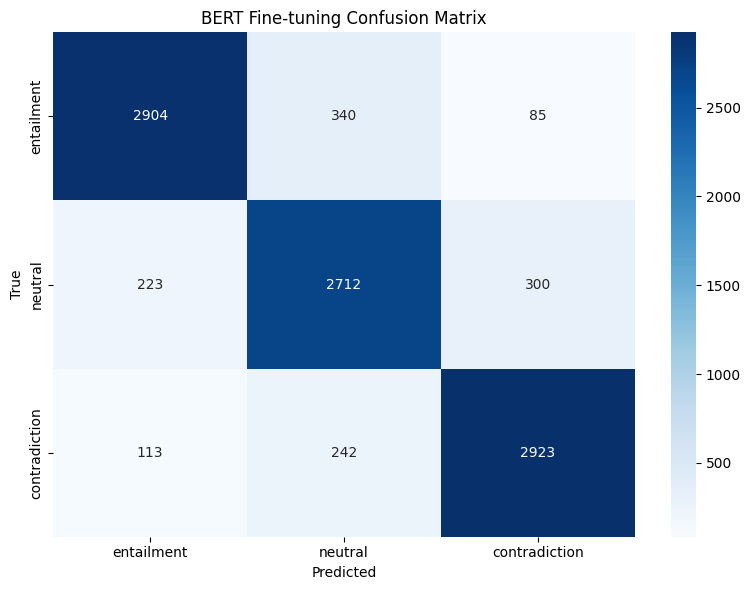

<Figure size 640x480 with 0 Axes>

In [19]:
results = trainer.detailed_evaluation(val_loader)

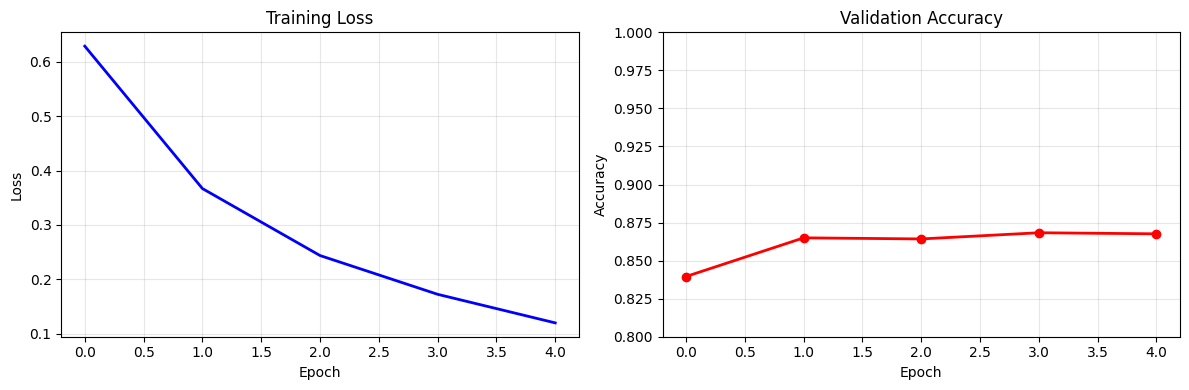

<Figure size 640x480 with 0 Axes>

In [20]:
trainer.plot_training_curves(train_losses, val_accuracies)

In [21]:
trainer.analyze_predictions(
    val_premises, val_hypotheses,
    results['predictions'], results['labels'], results['probabilities']
)


Analyzing predictions (showing 10 examples)...

Correct high-confidence predictions: 8306
Incorrect predictions: 1303
Low-confidence predictions: 39

Example incorrect predictions:

1. Premise: A woman is doing a cartwheel while wearing a bikini in the sand next to the beach.
   Hypothesis: A woman is doing a cartwheel and falls on her head.
   True: contradiction, Predicted: neutral (conf: 0.956)

2. Premise: Two women having drinks and smoking cigarettes at the bar.
   Hypothesis: Three women are at a bar.
   True: contradiction, Predicted: entailment (conf: 0.995)

3. Premise: At an outdoor event in an Asian-themed area, a crowd congregates as one person in a yellow Chinese dragon costume confronts the camera.
   Hypothesis: A crowd is dancing
   True: neutral, Predicted: contradiction (conf: 0.999)

4. Premise: At an outdoor event in an Asian-themed area, a crowd congregates as one person in a yellow Chinese dragon costume confronts the camera.
   Hypothesis: A crowd is in front o

In [22]:
trainer.model.save_pretrained('best_bert_model_86_83')
trainer.tokenizer.save_pretrained('best_bert_model_86_83')

('best_bert_model_86_83/tokenizer_config.json',
 'best_bert_model_86_83/special_tokens_map.json',
 'best_bert_model_86_83/vocab.txt',
 'best_bert_model_86_83/added_tokens.json')

# Inference

In [25]:
# In your notebook:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn.functional as F

# Load your saved model
model = BertForSequenceClassification.from_pretrained('/content/best_bert_model_86_83')
tokenizer = BertTokenizer.from_pretrained('/content/best_bert_model_86_83')

# Test a single example
premise = "A person is running in the park"
hypothesis = "someone is running in fear"

inputs = tokenizer(premise, hypothesis, return_tensors='pt',
                  truncation=True, padding='max_length', max_length=128)

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(outputs.logits, dim=-1)

labels = ['entailment', 'neutral', 'contradiction']
pred_label = labels[prediction.item()]
confidence = probs[0][prediction].item()

print(f"Premise: {premise}")
print(f"Hypothesis: {hypothesis}")
print(f"Prediction: {pred_label} (confidence: {confidence:.3f})")

Premise: A person is running in the park
Hypothesis: someone is running in fear
Prediction: neutral (confidence: 0.999)
